In [138]:
# necessary import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow.keras import models, layers
%matplotlib inline

In [172]:
## Some constants required for loading our datasets
img_size = 256
batch =32
n_c =3 # number of channels
epoch=50

### Load data set 
Data is taken from https://www.kaggle.com/arjuntejaswi/plant-village

In [140]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato",
    shuffle=True,
    image_size= (img_size,img_size),
    batch_size = batch
)

Found 2152 files belonging to 3 classes.


**Class names**

In [141]:
class_name = ds.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

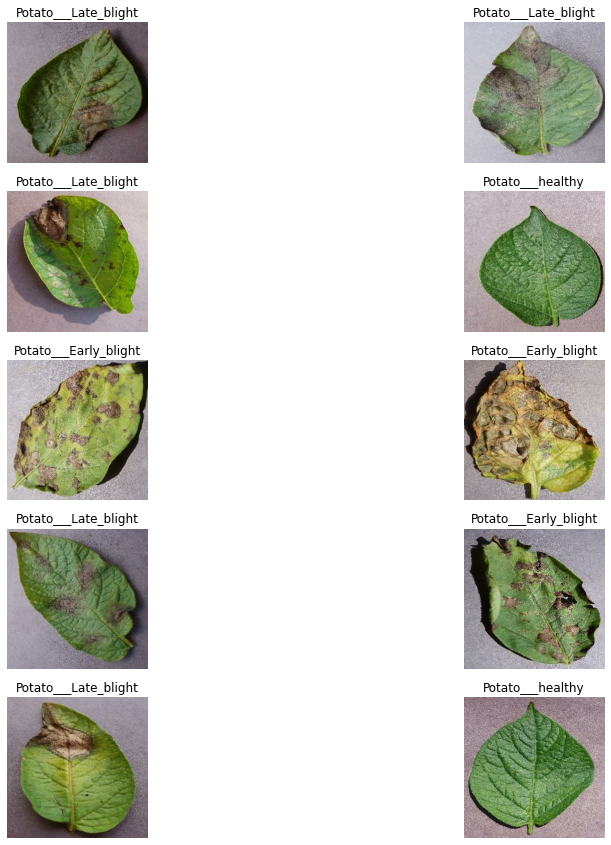

In [142]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in ds.take(2):
    for i in range(10):
        ax= plt.subplot(5,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

    

### Train Test Dev Split

In [143]:
def tran_test_dev(ds, train_p=0.80, val_p=0.1, test_p=  0.1, shuffle=True, shuffle_size=1000):
    train_size= int(len(ds)*train_p)
    val_size = int(len(ds)*val_p)
    test_size = int(len(ds)*test_p)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=123)
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, test_ds, val_ds

In [144]:
train_ds, test_ds, val_ds = tran_test_dev(ds)

In [145]:
print ('train_size is {}' .format(len(train_ds)))
print('test_size is {}' .format(len(test_ds)))
print('val_size is {}' .format(len(val_ds)))

train_size is 54
test_size is 8
val_size is 6


#### Using prefetch and cache for faster pre-processing

In [146]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Resize and rescale layers for CNN

In [147]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255.0)

])

In [149]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Let's create the CNN

In [152]:
n_c

3

In [159]:
input_shape=(batch,img_size,img_size,n_c)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size= (3,3), strides=(1,1), padding='same' ,activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(3, activation='softmax')
])
model.build(input_shape=input_shape)

In [160]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 256, 256, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 128, 128, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 126, 126, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 63, 63, 64)         0         
 g2D)                                                 

In [161]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [162]:
history= model.fit(
    train_ds,
    epochs =50,
    batch_size=batch,
    verbose= 1,
    validation_data= val_ds
)

Epoch 1/50
54/54 [==============================] - 25s 138ms/step - loss: 0.8866 - accuracy: 0.5229 - val_loss: 0.8309 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 6s 105ms/step - loss: 0.6791 - accuracy: 0.6813 - val_loss: 0.5551 - val_accuracy: 0.7083
Epoch 3/50
54/54 [==============================] - 6s 106ms/step - loss: 0.5352 - accuracy: 0.7711 - val_loss: 0.4537 - val_accuracy: 0.7917
Epoch 4/50
54/54 [==============================] - 6s 105ms/step - loss: 0.3890 - accuracy: 0.8251 - val_loss: 0.3235 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 6s 105ms/step - loss: 0.3258 - accuracy: 0.8668 - val_loss: 0.2662 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 6s 105ms/step - loss: 0.2510 - accuracy: 0.9067 - val_loss: 0.6674 - val_accuracy: 0.7135
Epoch 7/50
54/54 [==============================] - 6s 105ms/step - loss: 0.2887 - accuracy: 0.8791 - val_loss: 0.3421 - val_accuracy: 0.9115
Epoch

***Model is trained and ready for predictions :)***
#### But before making prediction, let's plot the loss and accuracy (train, val) against epoch

In [164]:
scores =  model.evaluate(test_ds)

8/8 [==============================] - 1s 45ms/step - loss: 0.0227 - accuracy: 0.9883


In [166]:
scores

[0.022678982466459274, 0.98828125]

In [168]:
## parameters for our model
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [169]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [171]:
acc= history.history['accuracy']
val_loss= history.history['val_loss']
val_accuracy= history.history['val_accuracy']
loss= history.history['loss']

Text(0.5, 1.0, 'Train and validation accuracy')

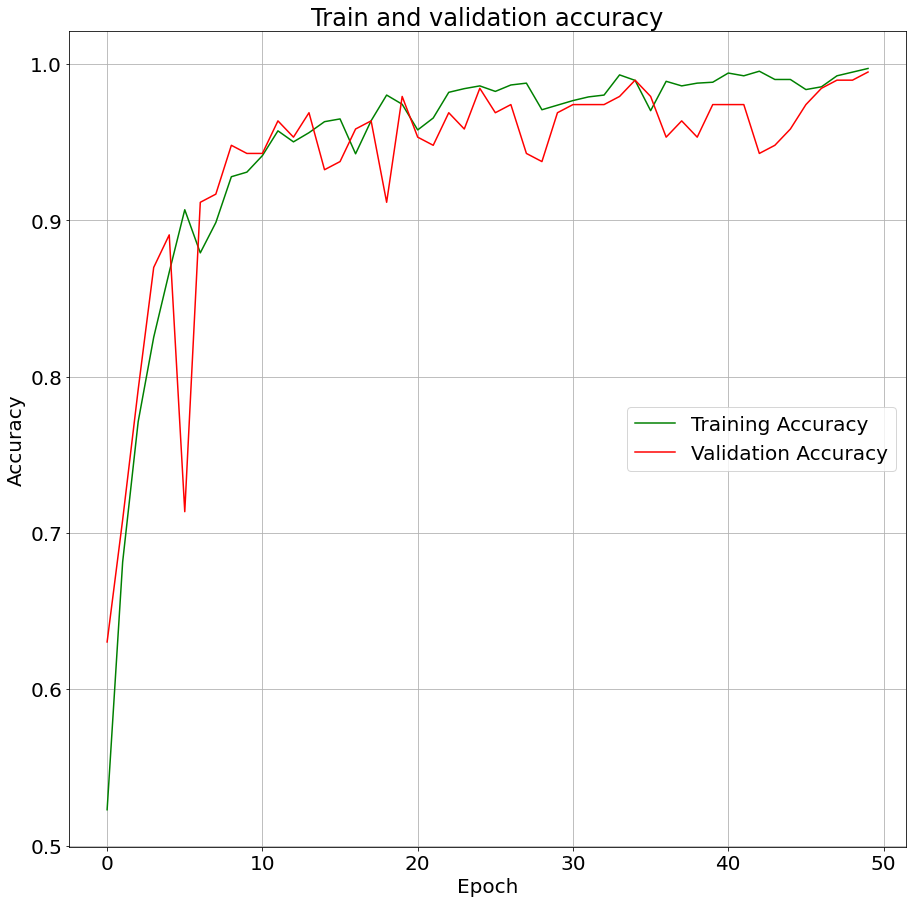

In [187]:
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size':20})
plt.plot(range(epoch), acc,label='Training Accuracy', color='g')
plt.plot(range(epoch), val_accuracy,label='Validation Accuracy',color='r')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc= 'right')
plt.grid()
plt.title('Train and validation accuracy')

Text(0.5, 1.0, 'Train and validation loss')

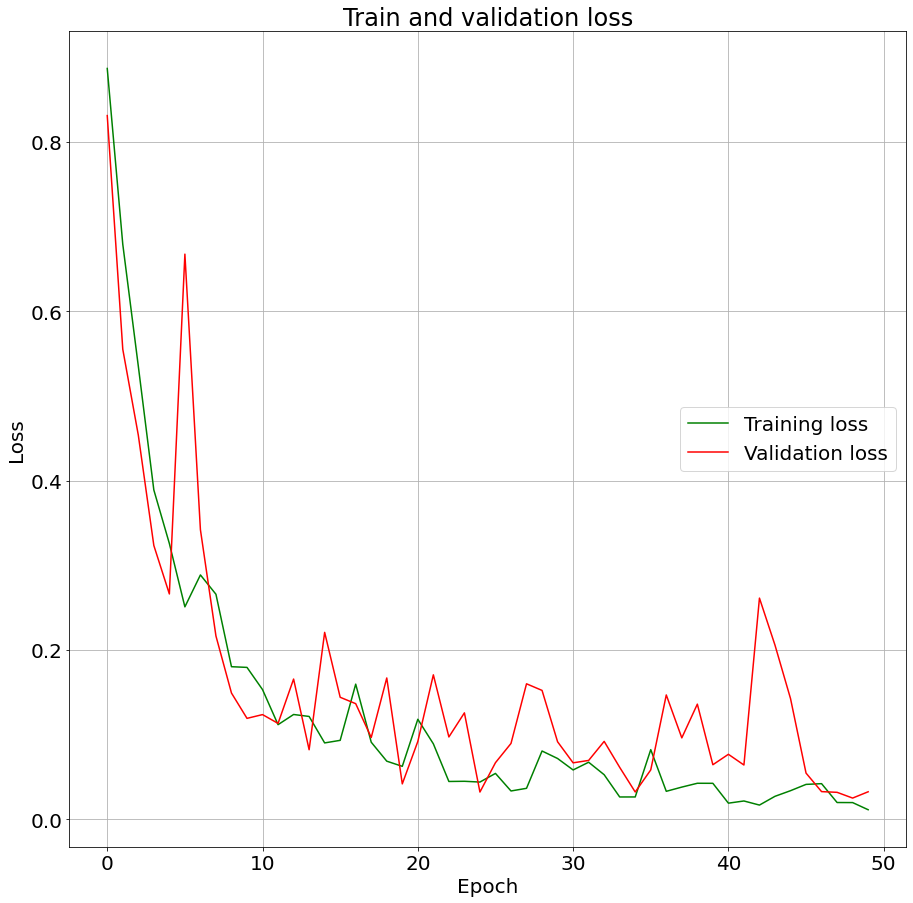

In [188]:
plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size':20})
plt.plot(range(epoch), loss,label='Training loss', color='g')
plt.plot(range(epoch),val_loss,label='Validation loss',color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc= 'right')
plt.grid()
plt.title('Train and validation loss')

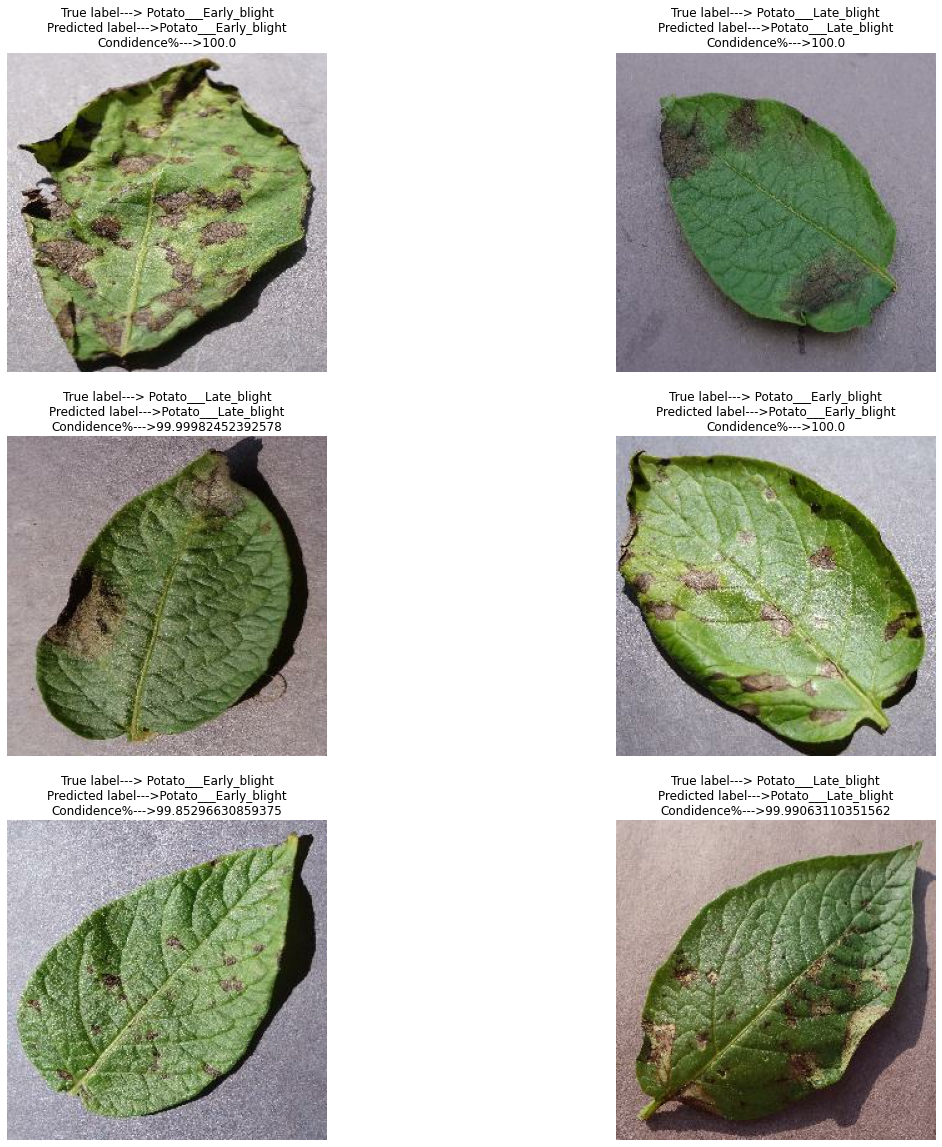

In [223]:
plt.figure(figsize=(20,20))
plt.rcParams.update({'font.size':10})
for image_batch, label_batch in test_ds.take(1):
    y_pred= model.predict(image_batch)
    for i in range(6):
        ax= plt.subplot(3,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title("True label---> {}".format(class_name[label_batch[i]])+
        '\n'+ "Predicted label--->{}".format(class_name[np.argmax(y_pred[i])])+
        '\n'+ "Condidence%--->{}".format(max(y_pred[i]*100))
        )
        
        plt.axis("off")

In [222]:
model_version='conv2d_CNN'
model.save(f"model")

INFO:tensorflow:Assets written to: model\assets


In [224]:
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']